# Init parameters

In [19]:
import re
import glob
from lsqfit import nonlinear_fit as nlinefit
import gvar as gv
import matplotlib.pyplot as plt
import numpy as np
%cd .
N_conf = 20000
N_dump = 5000
N_skip = 150 #to small
M = int((N_conf-N_dump)/N_skip)
# T = 50
# N_t = 500
# a = T/N_t
# delta = 1


/home/zhangxin/harm_oscil_1D


# Define some functions

In [20]:
def jaknf(u):
    return (np.sum(u, axis=0)-u)/(u.shape[0]-1)


def modelFunc(t, p: dict):
    return p['C0'] * np.exp(-p['E0'] * t * a)


def nonlinearFit(x, y, yerr, modelfunc: callable):
    fit = nlinefit(data=(x, gv.gvar(y, yerr)), prior=gv.gvar(
        dict(C0='1(100)', E0='1(100)')), fcn=modelfunc, debug=True)
    print(fit.format(True))
    params = [i.val for i in fit.p.values()]
    errors = [i.sdev for i in fit.p.values()]
    chi2 = fit.chi2 / fit.dof
    logGBF = fit.logGBF
    return params, errors, chi2, logGBF


def weight(u, t, a):
    u_b_t = u[(t-1+u.shape[0]) % u.shape[0]]
    u_f_t = u[(t+1) % u.shape[0]]
    u_t = u[t]
    S = (u_f_t-u_t)**2/(2.0*a)+a*(u_f_t**2+u_t**2)/4.0 + \
        (u_t-u_b_t)**2/(2.0*a)+a*(u_t**2+u_b_t**2)/4.0
    return np.exp(-1.0*S)


# Generating configurations

In [21]:
def genr_conf(Un, delta, a):
    old_u = np.zeros(Un.shape[1])
    new_u = np.zeros(Un.shape[1])
    for n in range(Un.shape[0]):
        t_iter = np.array(range(Un.shape[1]))
        np.random.shuffle(t_iter)
        for t in t_iter:
            new_u[t] = old_u[t]+delta*np.random.uniform(-1, 1)
            if np.random.uniform(0, 1) < weight(new_u, t, a)/weight(old_u, t, a):
                old_u[t] = new_u[t]
            else:
                new_u[t] = old_u[t]
        Un[n, :] = new_u
    return Un


def save_conf(Un, N_dump, N_skip, a):
    Um = Un[N_dump:Un.shape[0]:N_skip, :]
    np.save("Um_"+str(N_dump)+"_"+str(N_skip)+"_" +
            str(Un.shape[0])+"_"+str(Un.shape[1])+"_"+str(a)+".npy", Um)
    return Um


def conf(N_conf, N_dump, N_skip, N_t, a, delta):
    Un = np.zeros((N_conf, N_t))
    Un = genr_conf(Un, delta, a)
    return save_conf(Un, N_dump, N_skip, a)
# Um = conf(N_conf, N_dump, N_skip, N_t, 0.60, delta)
# Um = conf(N_conf, N_dump, N_skip, N_t, 0.64, delta)

# Load data

In [22]:
path = './_500_a/'
pattern = re.compile(r'.*.npy')

files = glob.glob(path + '*.npy')
files = [f for f in files if pattern.match(f)]
Um_5000_150_20000_500_a_dict = {}
for f in files:
    key = f.split('_')[-1].split('.npy')[0]
    key = round(float(key), 2)
    data = np.load(f)
    Um_5000_150_20000_500_a_dict[key] = data

path = './_N_t_0.1/'
pattern = re.compile(r'.*.npy')

files = glob.glob(path + '*.npy')
files = [f for f in files if pattern.match(f)]
Um_5000_150_20000_N_t_0_1_0_dict = {}
for f in files:
    key = f.split('_')[-2]
    key = round(float(key), -1)
    data = np.load(f)
    Um_5000_150_20000_N_t_0_1_0_dict[key] = data

path = './_N_t_0.0.1/'
pattern = re.compile(r'.*.npy')

files = glob.glob(path + '*.npy')
files = [f for f in files if pattern.match(f)]
Um_5000_150_20000_N_t_0_0_1_dict = {}
for f in files:
    key = f.split('_')[-2]
    key = round(float(key), -1)
    data = np.load(f)
    Um_5000_150_20000_N_t_0_0_1_dict[key] = data

# Give Theoretical value

In [23]:
def give_theo_val(a, N_t):
    theo_u_2 = np.zeros(N_t)
    R = 1+a**2/4.0-a*(1+a**2/4.0)**0.5
    C = 0.5*(1+a**2/4.0)**(-0.5)
    for t in range(N_t):
        try:
            theo_u_2[t] = C*(1+R**t)/(1-R**t)
        except ZeroDivisionError:
            theo_u_2[t] = C
    return theo_u_2

# Test

In [24]:
# # # Um = conf(20000, 5000, 150, 5000, 0.01, 1)
# Um = np.load("./Um_5000_300_35000_500_0.05.npy")
# # Um_list = Um[::50, :]
# # print(len(Um_list))
# # u_2_list = [np.mean(np.mean(i**2)) for i in Um_list]
# # mean_u_2_list = np.mean(u_2_list)
# # err_u_2_list = np.std(u_2_list)
# # print(mean_u_2_list,err_u_2_list)
# # print(np.mean(jaknf(np.mean(Um**2, axis=1))))
# # print(Um)
# # Um = conf(20000, 5000, 150, 5000, 0.01, 1)
# u_2_m = jaknf(np.mean(Um**2, axis=1))
# u_2_m_mean = np.mean(u_2_m)
# u_2_m_err = (100-1)**0.5*np.std(u_2_m)
# print(u_2_m_mean, u_2_m_err)

# Measuring the ground energy

*********HARM_OSCIL_1D_GROUND_ENERGY*********


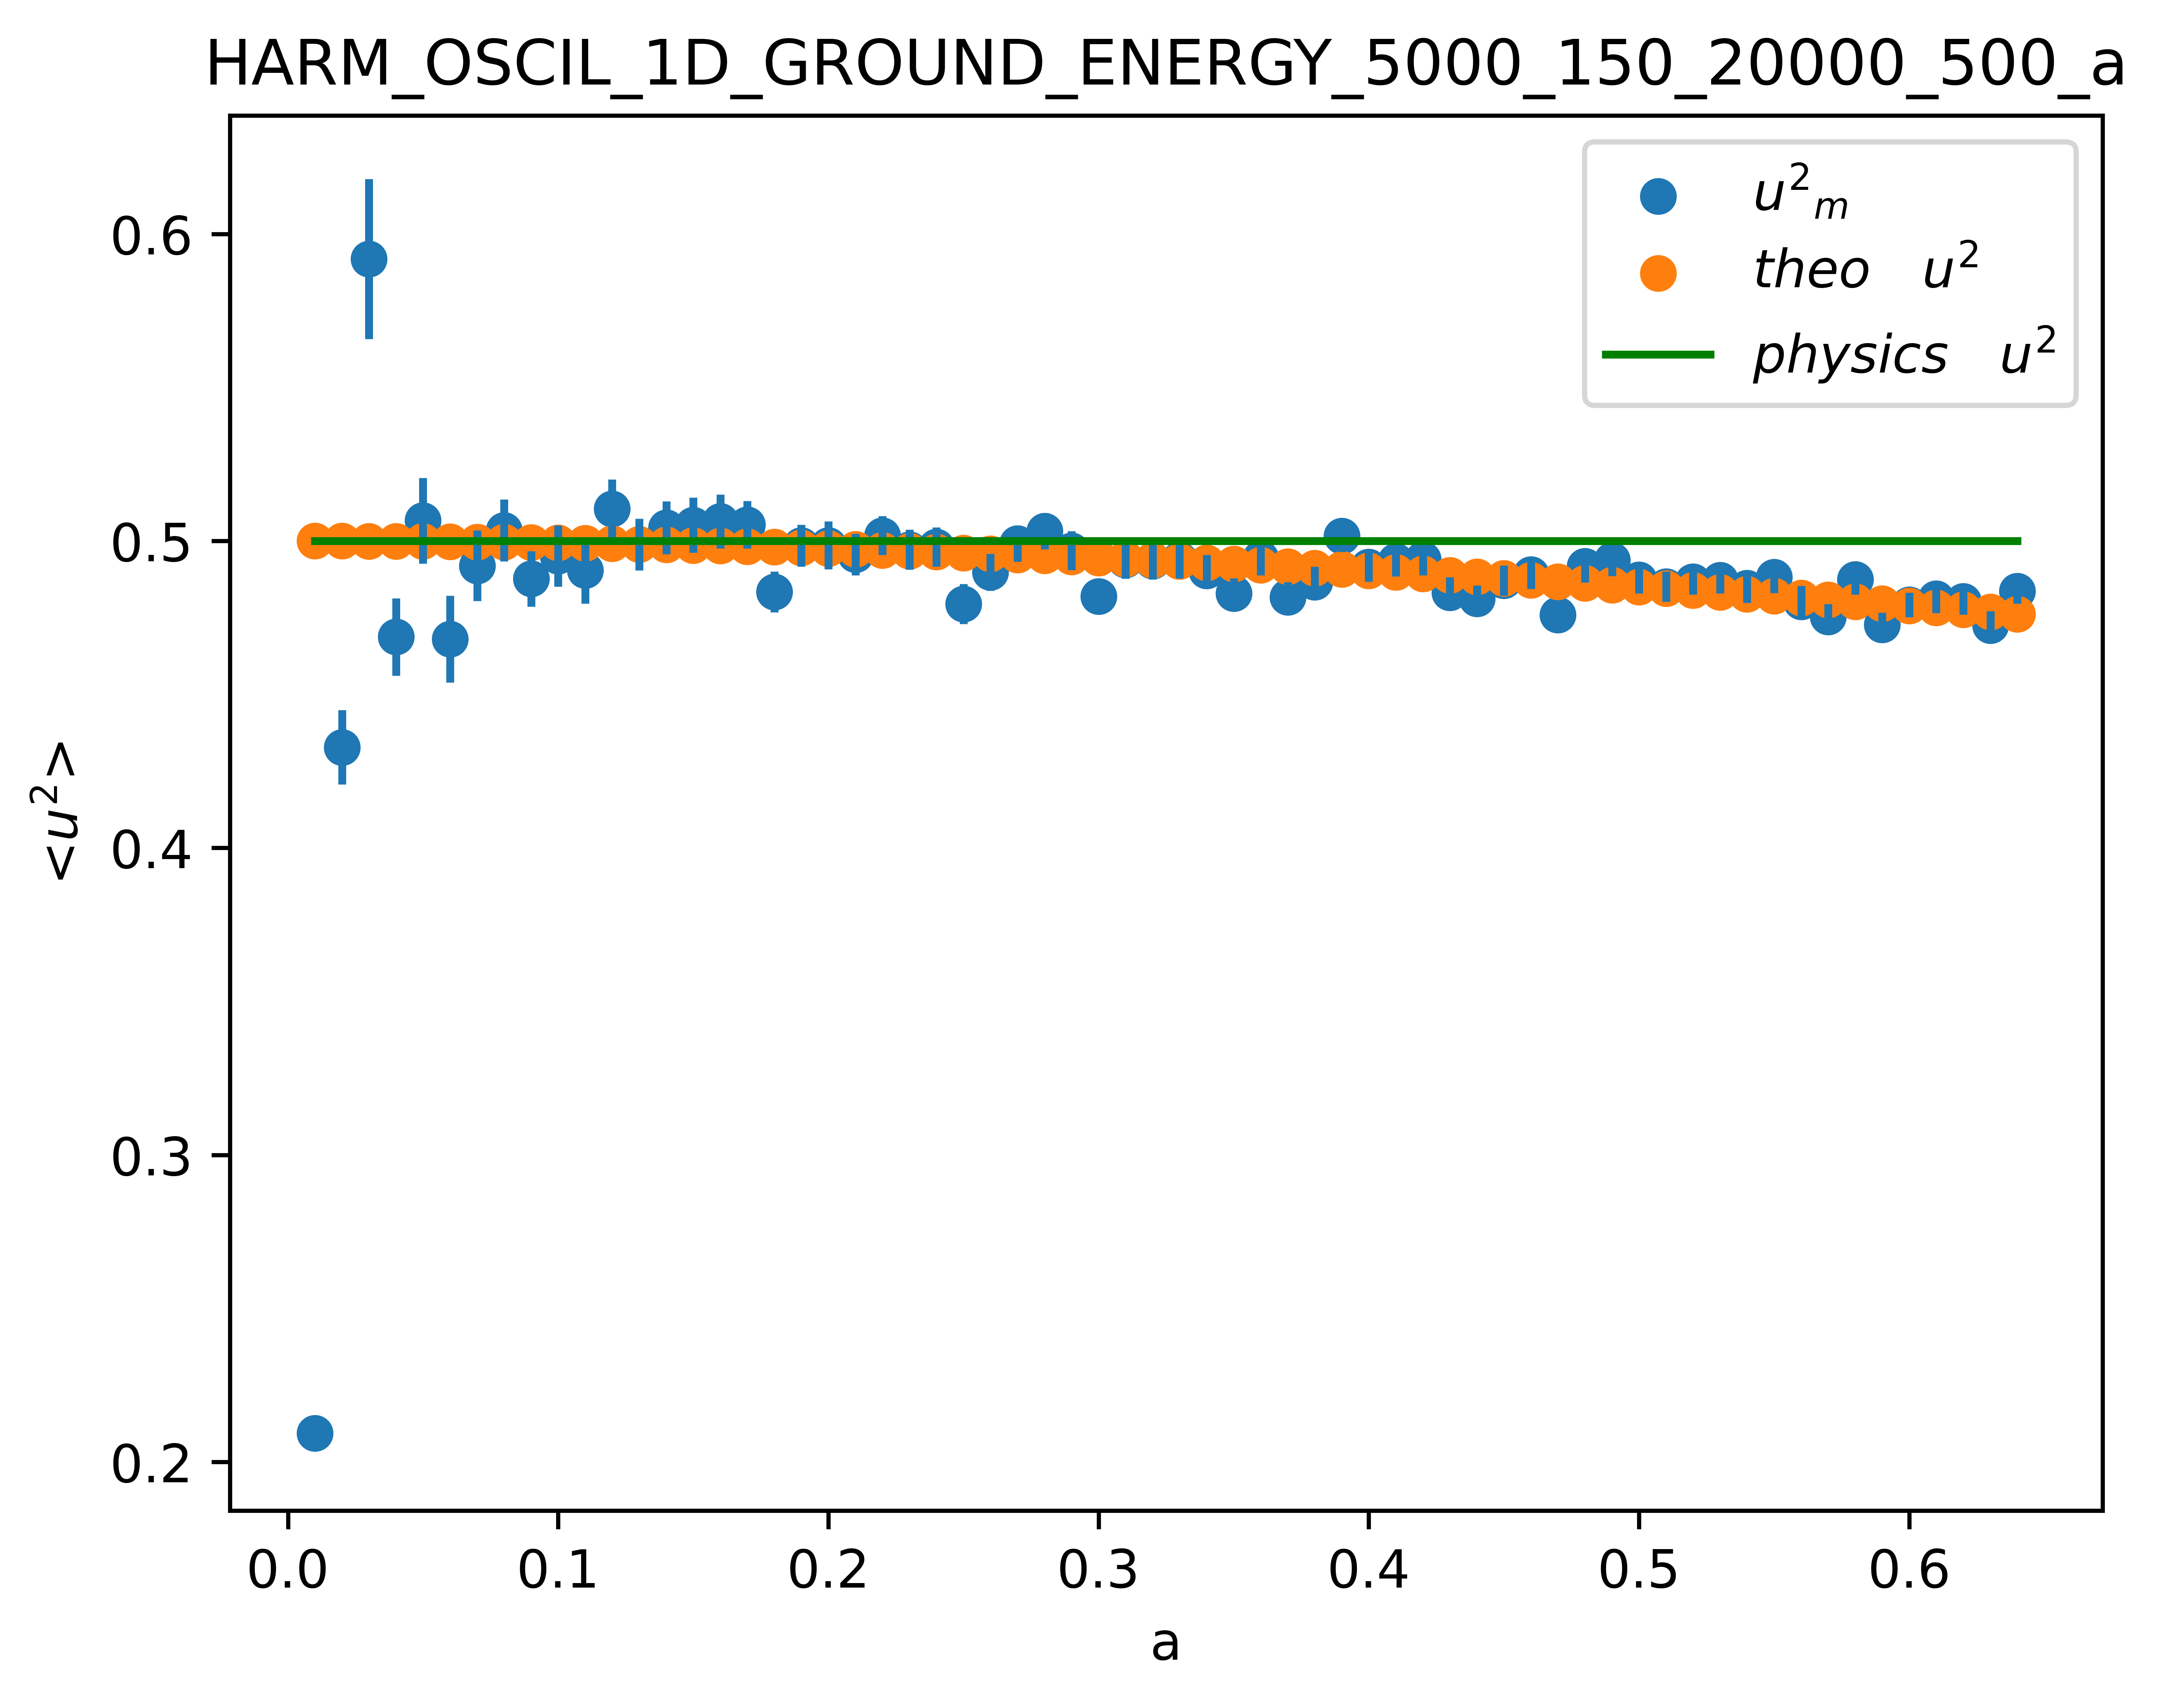

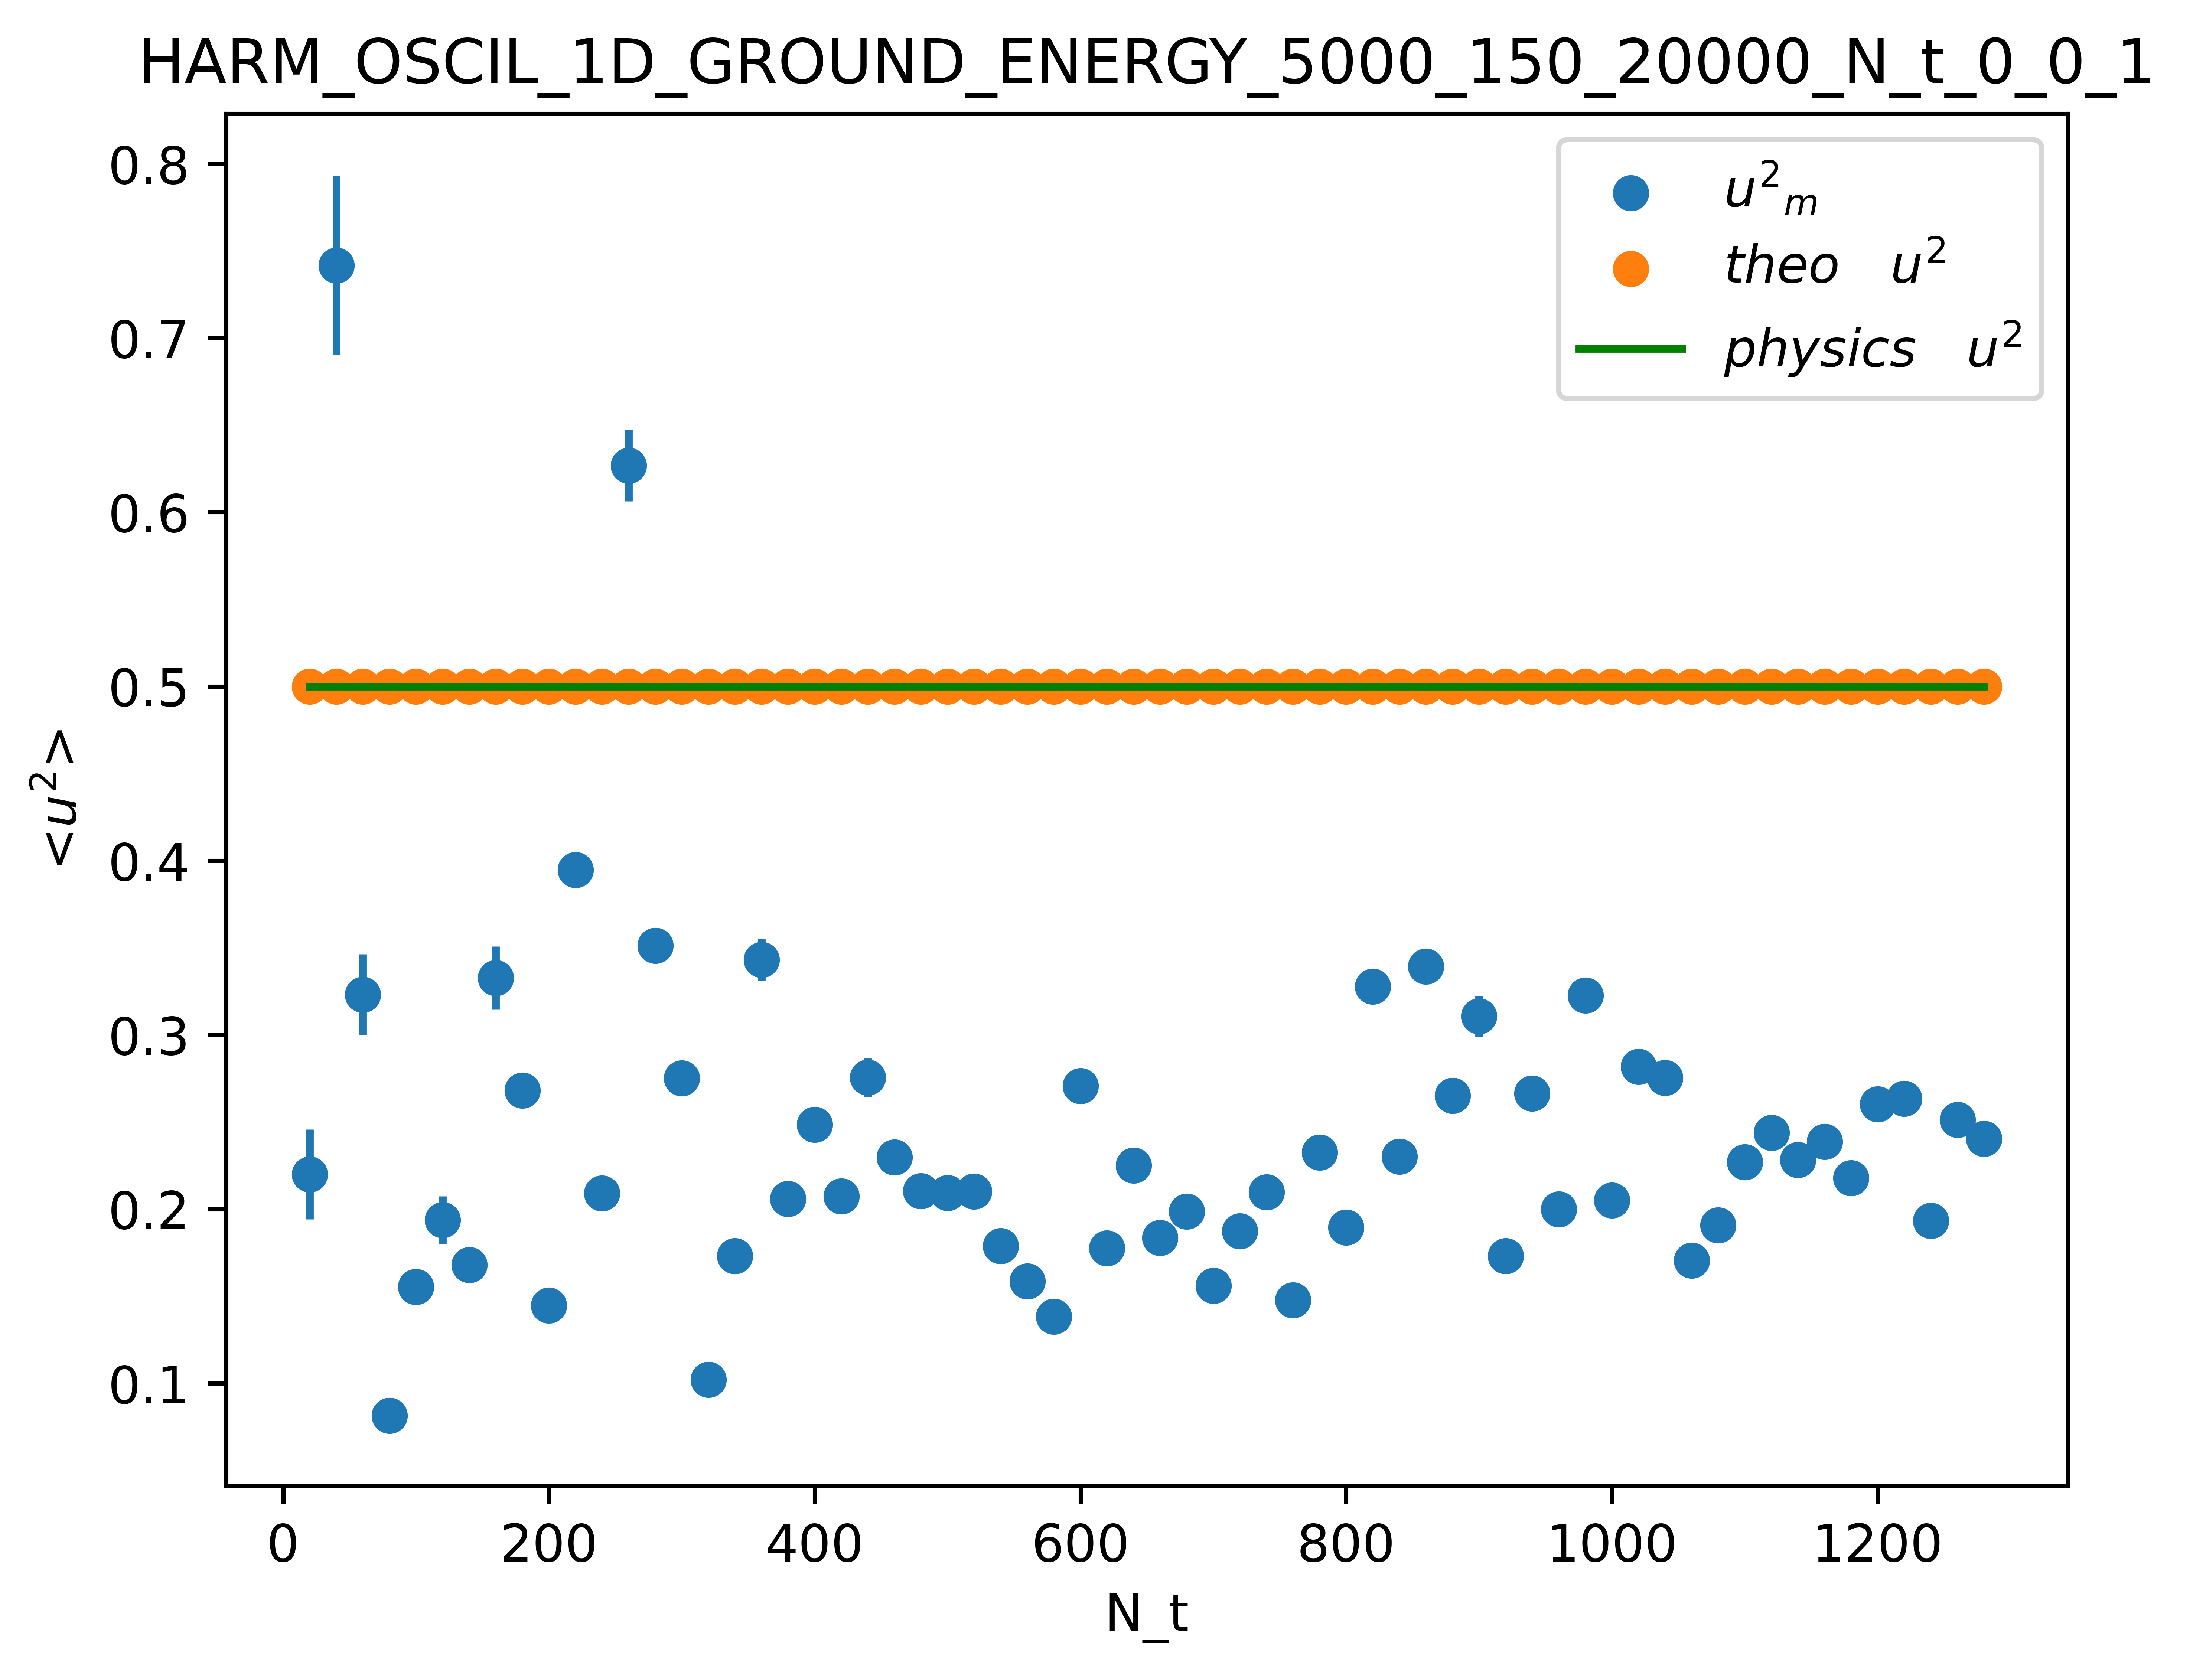

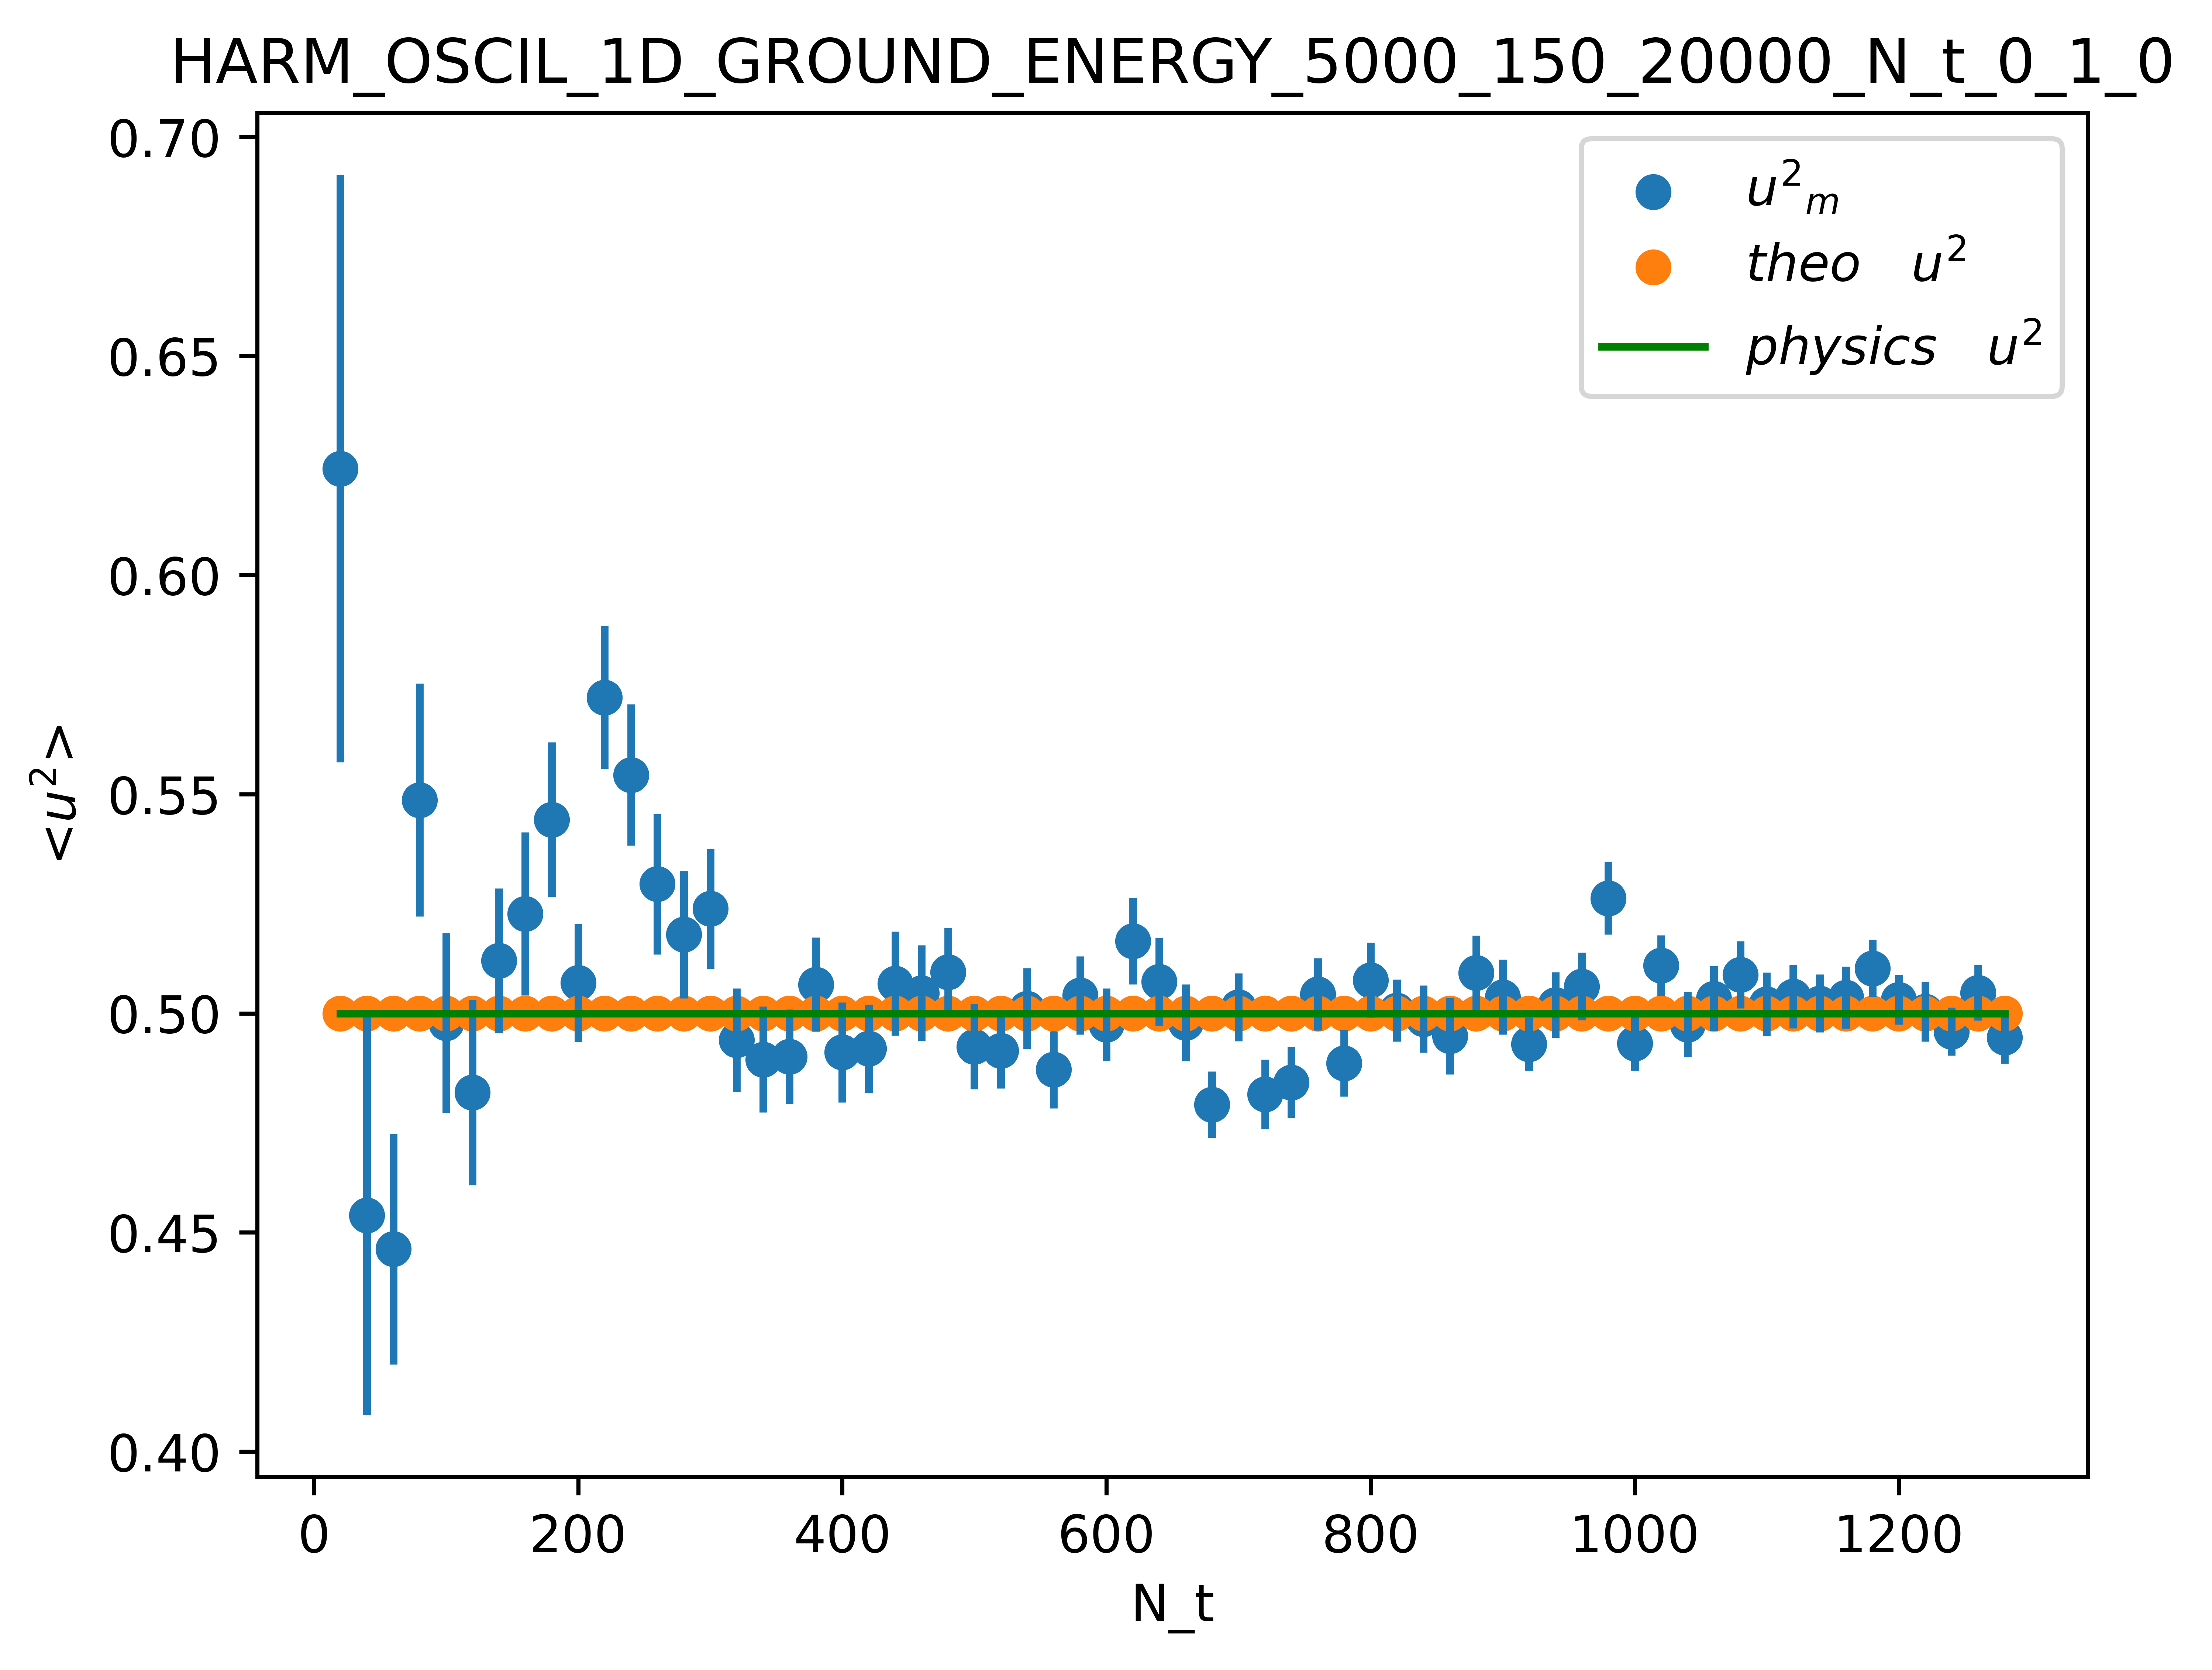

In [25]:
print("*********HARM_OSCIL_1D_GROUND_ENERGY*********")
u_2_data_list = np.array([np.mean(
    jaknf(np.mean(Um_5000_150_20000_500_a_dict[round(0.01+i*0.01, 2)]**2, axis=1)))for i in range(64)])
u_2_err_list = (100-1)**0.5 * np.array([np.std(
    jaknf(np.mean(Um_5000_150_20000_500_a_dict[round(0.01+i*0.01, 2)]**2, axis=1)))for i in range(64)])
plt.figure(dpi=1000)
a_iter = np.array([round(0.01+i*0.01, 2) for i in range(64)])
u_2_theo_data_list = [
    0.5*(1+round(0.01+i*0.01, 2)**2/4.0)**(-0.5) for i in range(64)]
plt.scatter(x=a_iter, y=u_2_data_list, label="${u^2}_m$")
plt.scatter(x=a_iter, y=u_2_theo_data_list, label="$theo \quad u^2$")
plt.errorbar(
    x=a_iter, y=u_2_data_list, yerr=u_2_err_list, ls='none')
plt.plot(a_iter, [0.5]*len(a_iter),
         label="$physics \quad u^2$", color='green')
# plt.fill_between(x=a_iter, y1=u_2_data_list-u_2_err_list,
#                  y2=u_2_data_list+u_2_err_list, alpha=0.3)
plt.title("HARM_OSCIL_1D_GROUND_ENERGY_5000_150_20000_500_a")
plt.xlabel("a")
plt.ylabel("<$u^2$>")
plt.legend()
plt.savefig("HARM_OSCIL_1D_GROUND_ENERGY_5000_150_20000_500_a.png")
plt.show()

u_2_data_list = np.array([np.mean(
    jaknf(np.mean(Um_5000_150_20000_N_t_0_0_1_dict[round(20+i*20, -1)]**2, axis=1)))for i in range(64)])
u_2_err_list = (100-1)**0.5 * np.array([np.std(
    jaknf(np.mean(Um_5000_150_20000_N_t_0_0_1_dict[round(20+i*20, -1)]**2, axis=1)))for i in range(64)])
plt.figure(dpi=1000)
N_t_iter = np.array([round(20+i*20, -1) for i in range(64)])
u_2_theo_data_list = [
    0.5*(1+0.01**2/4.0)**(-0.5) for i in range(64)]
plt.scatter(x=N_t_iter, y=u_2_data_list, label="${u^2}_m$")
plt.scatter(x=N_t_iter, y=u_2_theo_data_list, label="$theo \quad u^2$")
plt.errorbar(
    x=N_t_iter, y=u_2_data_list, yerr=u_2_err_list, ls='none')
plt.plot(N_t_iter, [0.5]*len(N_t_iter),
         label="$physics \quad u^2$", color='green')

# plt.fill_between(x=N_t_iter, y1=u_2_data_list-u_2_err_list,
#                  y2=u_2_data_list+u_2_err_list, alpha=0.3)
plt.title("HARM_OSCIL_1D_GROUND_ENERGY_5000_150_20000_N_t_0_0_1")
plt.xlabel("N_t")
plt.ylabel("<$u^2$>")
plt.legend()
plt.savefig("HARM_OSCIL_1D_GROUND_ENERGY_5000_150_20000_N_t_0_0_1.png")
plt.show()

u_2_data_list = np.array([np.mean(
    jaknf(np.mean(Um_5000_150_20000_N_t_0_1_0_dict[round(20+i*20, -1)]**2, axis=1)))for i in range(64)])
u_2_err_list = (100-1)**0.5 * np.array([np.std(
    jaknf(np.mean(Um_5000_150_20000_N_t_0_1_0_dict[round(20+i*20, -1)]**2, axis=1)))for i in range(64)])
plt.figure(dpi=1000)
N_t_iter = np.array([round(20+i*20, -1) for i in range(64)])
u_2_theo_data_list = [
    0.5*(1+0.01**2/4.0)**(-0.5) for i in range(64)]
plt.scatter(x=N_t_iter, y=u_2_data_list, label="${u^2}_m$")
plt.scatter(x=N_t_iter, y=u_2_theo_data_list, label="$theo \quad u^2$")
plt.errorbar(
    x=N_t_iter, y=u_2_data_list, yerr=u_2_err_list, ls='none')
plt.plot(N_t_iter, [0.5]*len(N_t_iter),
         label="$physics \quad u^2$", color='green')

# plt.fill_between(x=N_t_iter, y1=u_2_data_list-u_2_err_list,
#                  y2=u_2_data_list+u_2_err_list, alpha=0.3)
plt.title("HARM_OSCIL_1D_GROUND_ENERGY_5000_150_20000_N_t_0_1_0")
plt.xlabel("N_t")
plt.ylabel("<$u^2$>")
plt.legend()
plt.savefig("HARM_OSCIL_1D_GROUND_ENERGY_5000_150_20000_N_t_0_1_0.png")
plt.show()

# Measuring the excited state energy


In [26]:
# Um = Um_5000_150_20000_500_a_dict[0.1]
# N_t = 500
# Ct = []
# jk_Um = jaknf(Um)
# for m in range(M):
#     tmp_list = []
#     for t in range(N_t):
#         tmp_list.append(
#             np.mean([Um[m, (t+t0) % N_t]*Um[m, t0] for t0 in range(N_t)]))
#     Ct.append(tmp_list)
# Ct = np.array(Ct)
# np.save("Ct.npy", Ct)

In [27]:
Ct = np.load("Ct.npy")

*********HARM_OSCIL_1D_EXCITED_STATE_ENERGY*********


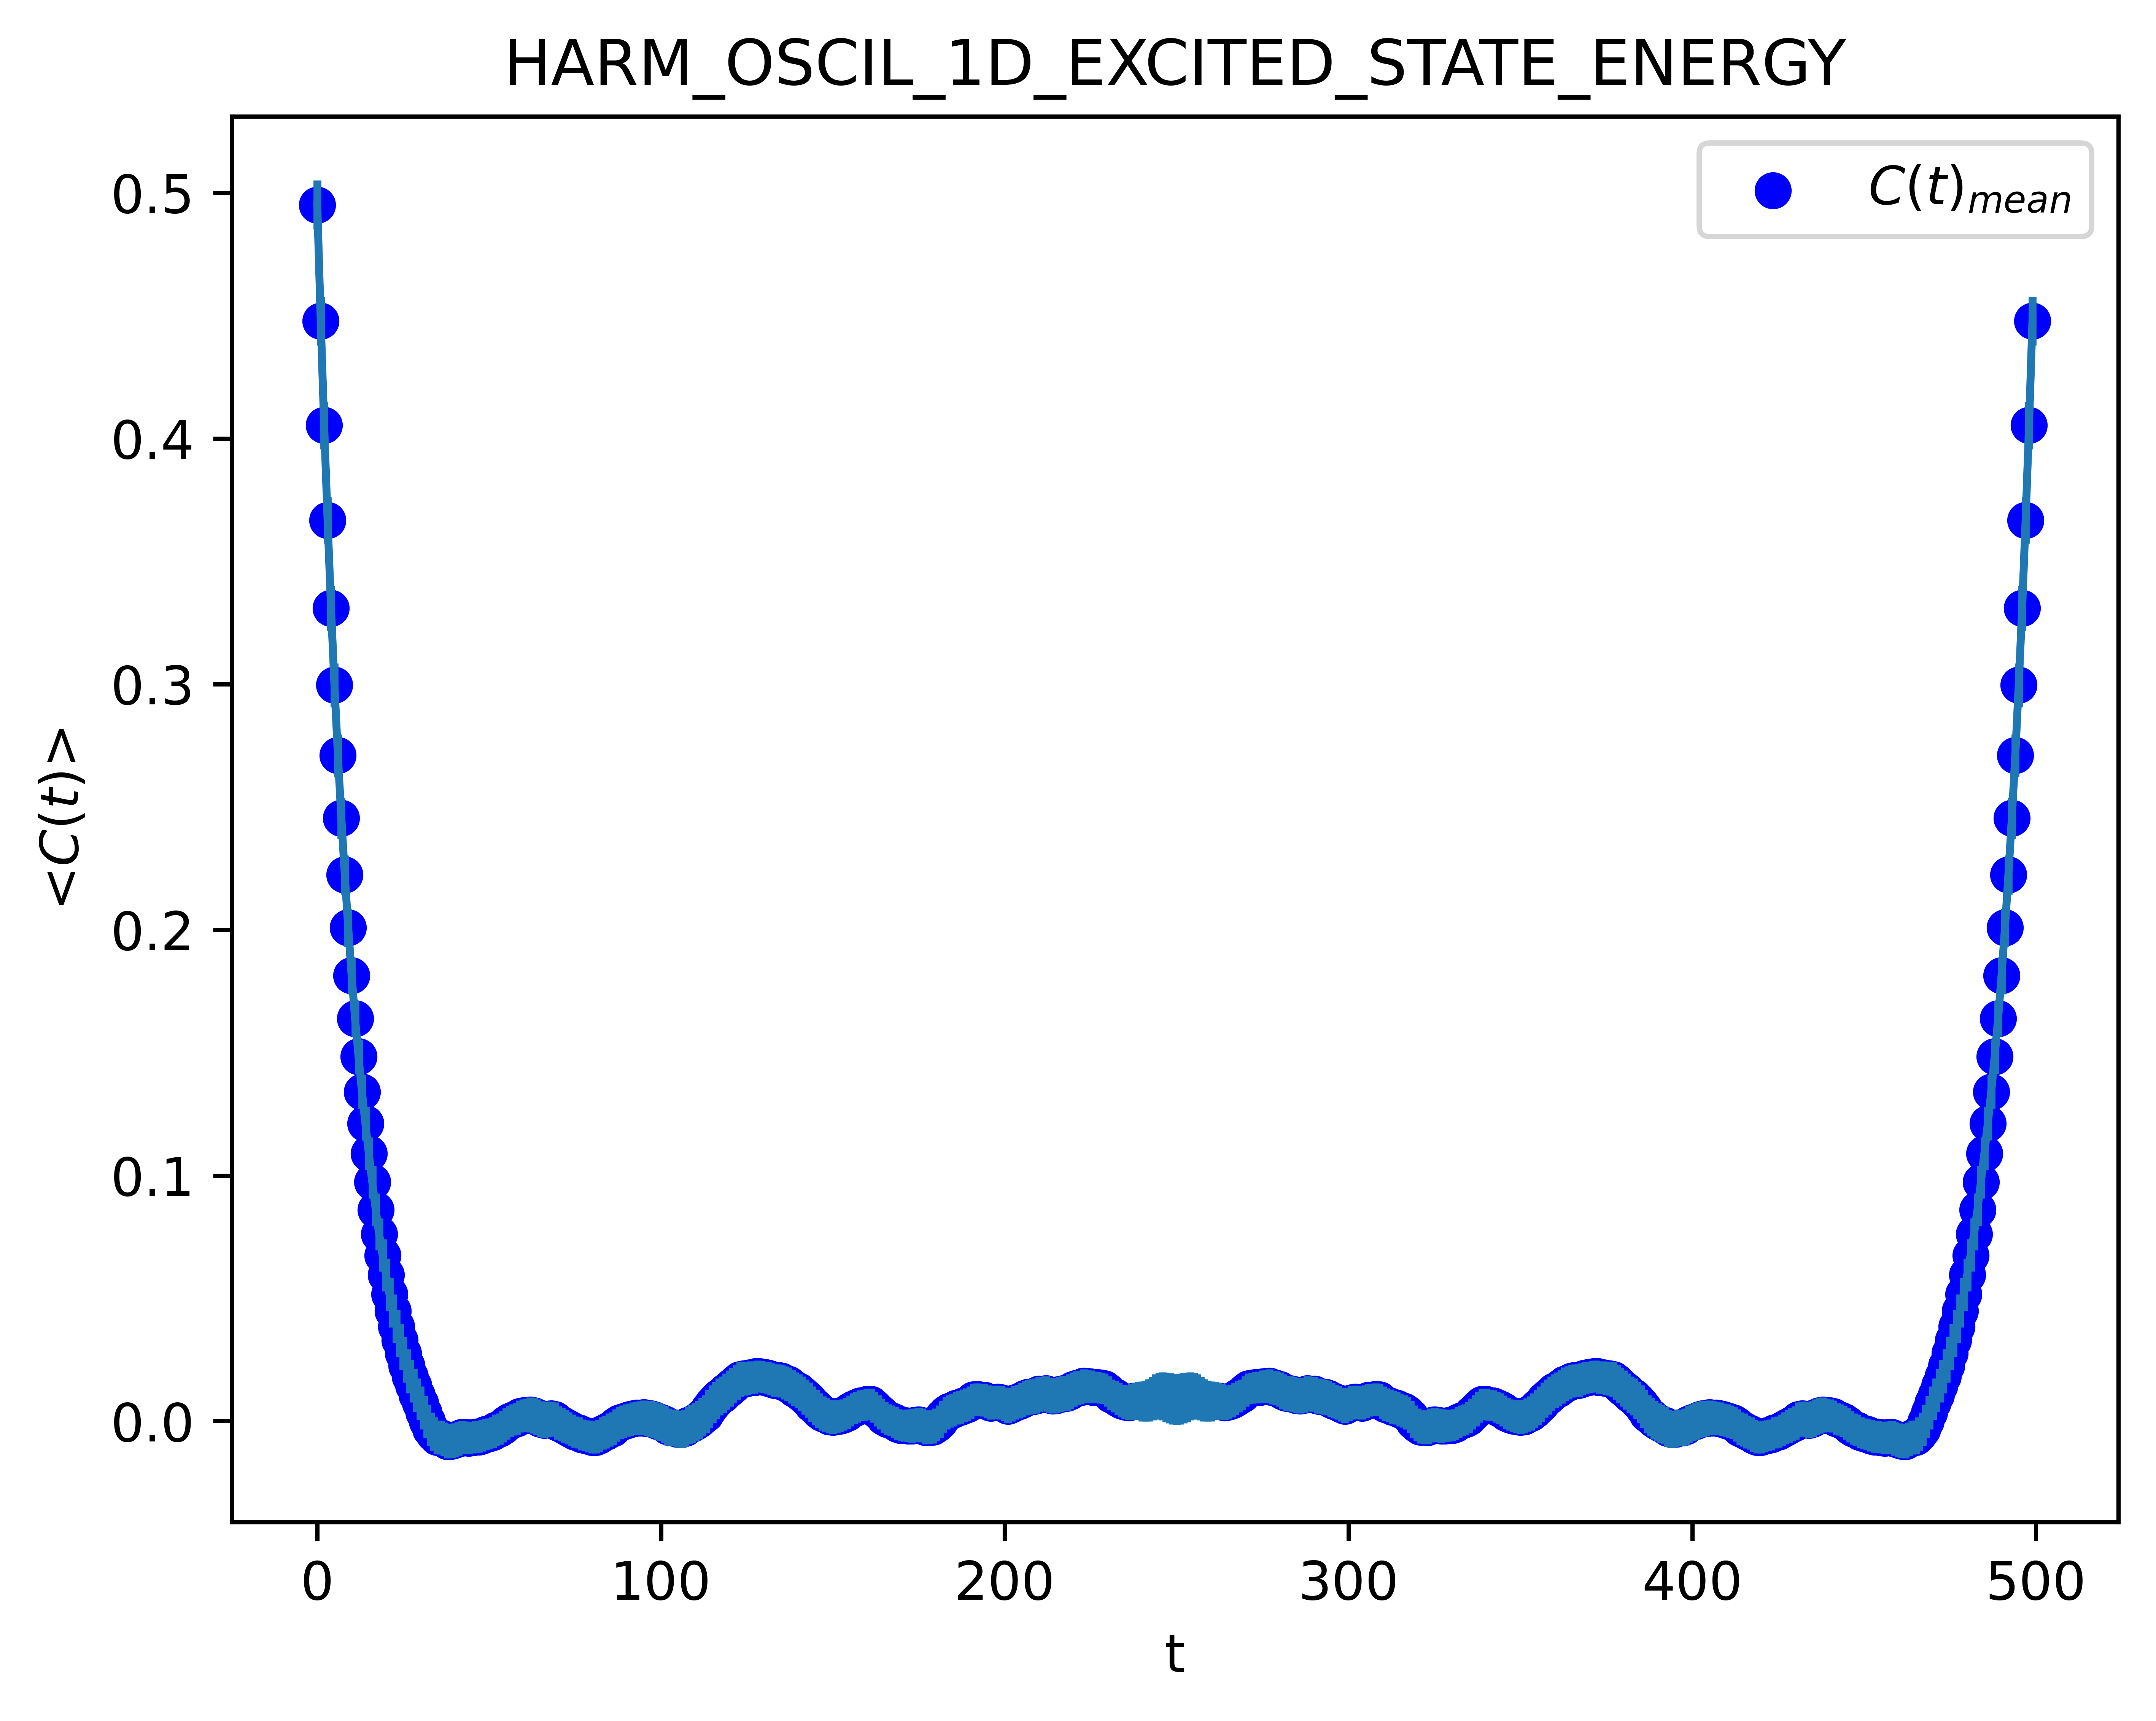

Least Square Fit:
  chi2/dof [dof] = 1 [15]    Q = 0.41    logGBF = 82.862

Parameters:
             C0   0.471 (10)     [    1 (100) ]  
             E0   0.999 (30)     [    1 (100) ]  

Fit:
     x[k]           y[k]      f(x[k],p)
---------------------------------------
        5    0.2853 (88)    0.2860 (82)  
        6    0.2582 (85)    0.2588 (79)  
        7    0.2339 (82)    0.2342 (77)  
        8    0.2116 (79)    0.2120 (75)  
        9    0.1911 (77)    0.1918 (72)  
       10    0.1726 (74)    0.1736 (70)  
       11    0.1561 (72)    0.1571 (67)  
       12    0.1412 (70)    0.1421 (65)  
       13    0.1276 (69)    0.1286 (62)  
       14    0.1150 (68)    0.1164 (59)  
       15    0.1031 (66)    0.1053 (56)  
       16    0.0917 (66)    0.0953 (54)  
       17    0.0811 (66)    0.0862 (51)  
       18    0.0718 (66)    0.0780 (48)  
       19    0.0635 (66)    0.0706 (46)  *

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 5/0.0)
  fitter =

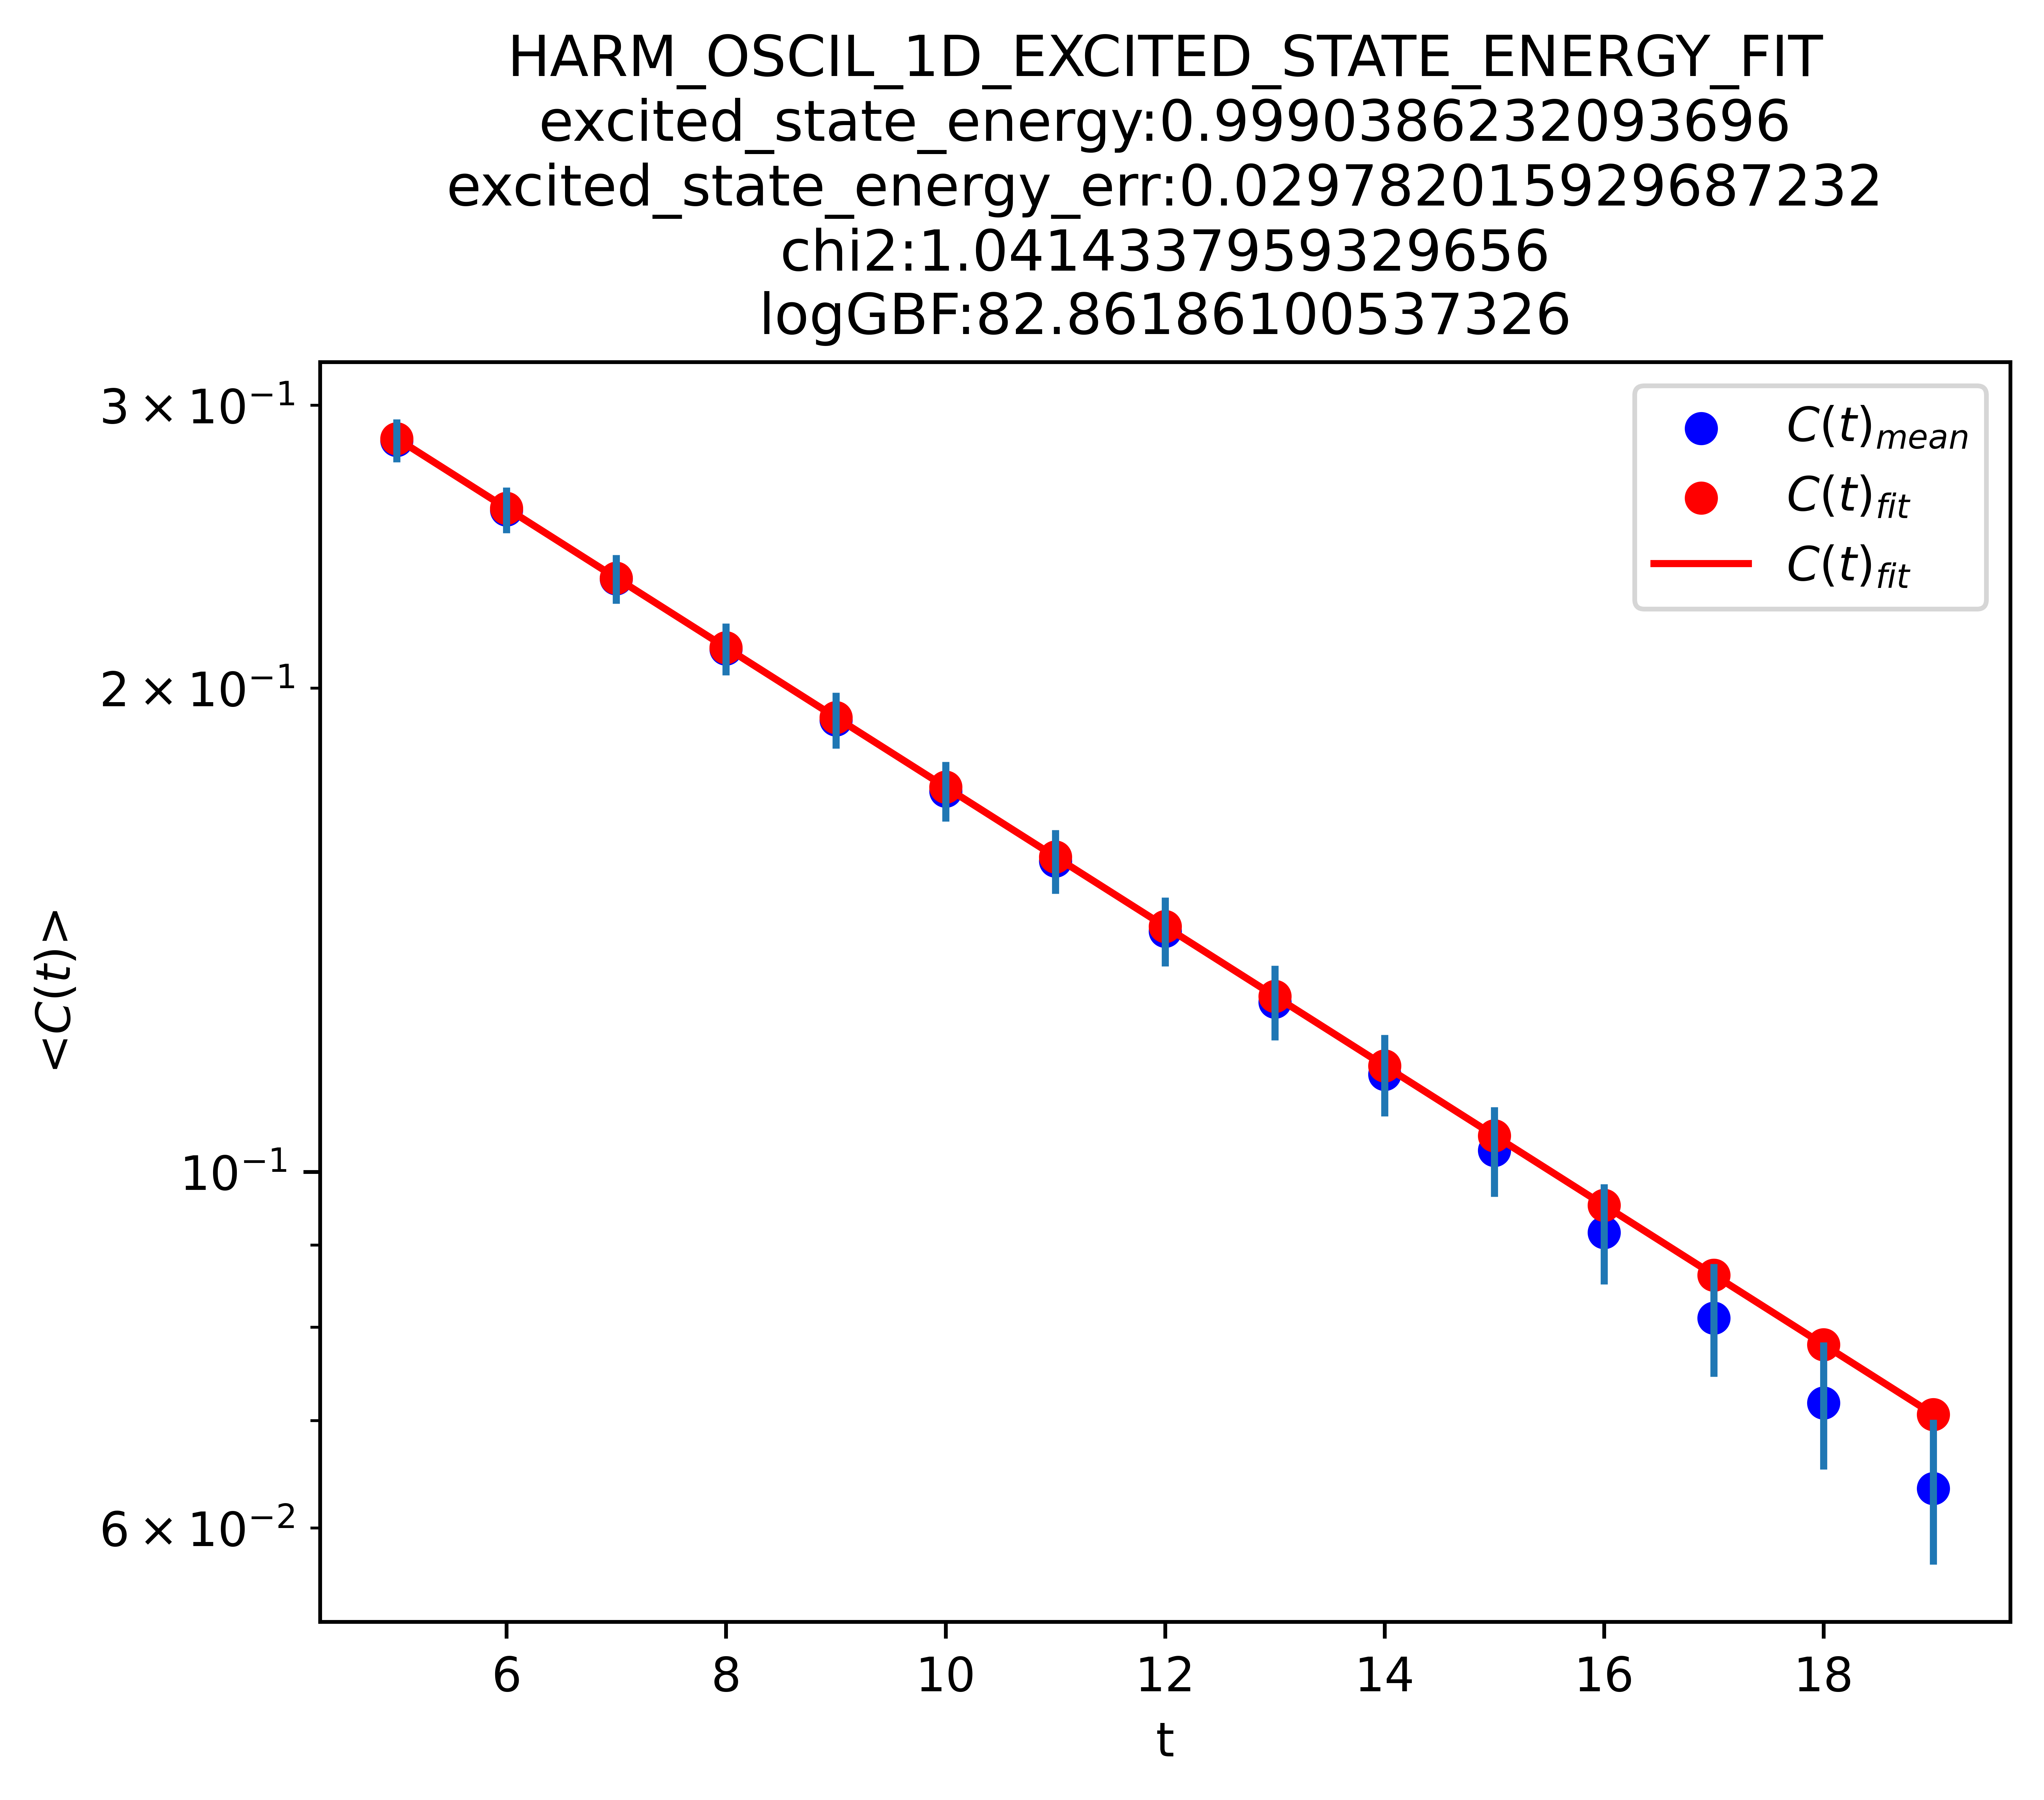

In [30]:
a = 0.1
N_t = 500
jk_Ct = jaknf(Ct)
jk_Ct_mean = np.mean(jk_Ct, axis=0)
jk_Ct_err = (jk_Ct.shape[0]-1)**0.5*np.std(jk_Ct, axis=0)
print("*********HARM_OSCIL_1D_EXCITED_STATE_ENERGY*********")
plt.figure(dpi=1000)
t_iter = np.array(range(jk_Ct.shape[1]))
plt.scatter(x=t_iter, y=jk_Ct_mean, label="${C(t)}_{mean}$", color='blue')
plt.errorbar(
    x=t_iter, y=jk_Ct_mean, yerr=jk_Ct_err)
plt.fill_between(x=t_iter, y1=jk_Ct_mean-jk_Ct_err,
                 y2=jk_Ct_mean+jk_Ct_err, alpha=0.3)
plt.xlabel("t")
plt.ylabel("<$C(t)$>")
plt.legend()
plt.title("HARM_OSCIL_1D_EXCITED_STATE_ENERGY")
plt.savefig("HARM_OSCIL_1D_EXCITED_STATE_ENERGY.png")
plt.show()

t_start = 5
t_end = 20
t_iter_ = t_iter[t_start:t_end]
Ct_ = (Ct[:, t_start:t_end:]+Ct[:, N_t-t_end:N_t-t_start:][:, ::-1])/2
jk_Ct_ = jaknf(Ct_)
jk_Ct_mean_ = np.mean(jk_Ct_, axis=0)
jk_Ct_err_ = (jk_Ct_.shape[0]-1)**0.5*np.std(jk_Ct_, axis=0)
jk_Ct_cov_ = (jk_Ct_.shape[0]-1)*np.cov(np.transpose(jk_Ct_, axes=(1, 0)))
params, errors, chi2, logGBF = nonlinearFit(
    x=t_iter_, y=jk_Ct_mean_, yerr=jk_Ct_cov_, modelfunc=modelFunc)
plt.figure(dpi=1000)
plt.scatter(x=t_iter_, y=jk_Ct_mean_,
            label="${C(t)}_{mean}$", color='blue')
plt.scatter(x=t_iter_, y=[params[0]*np.exp(-t*a*params[1])
            for t in t_iter_], label="${C(t)}_{fit}$", color='red')
plt.plot(t_iter_, [params[0]*np.exp(-t*a*params[1])
                   for t in t_iter_], label="${C(t)}_{fit}$", color='red')
plt.errorbar(
    x=t_iter_, y=jk_Ct_mean_, yerr=jk_Ct_err_, ls='none')
# plt.fill_between(x=t_iter_, y1=jk_Ct_mean_-jk_Ct_err_,
#                  y2=jk_Ct_mean_+jk_Ct_err_, alpha=0.3)
plt.xlabel("t")
plt.ylabel("<$C(t)$>")
plt.yscale("log")
plt.legend()
plt.title("HARM_OSCIL_1D_EXCITED_STATE_ENERGY_FIT"+"\nexcited_state_energy:" +
          str(params[1])+"\nexcited_state_energy_err:"+str(errors[1])+"\nchi2:"+str(chi2)+"\nlogGBF:"+str(logGBF))
plt.savefig("HARM_OSCIL_1D_EXCITED_STATE_ENERGY_FIT.png")
plt.show()